<a href="https://colab.research.google.com/github/Zachary-Wenhao/IML-Team-Attack-Diffusion-Model/blob/data-preparation/Dataset_generation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install datasets
!pip install numpy
!pip install torch

In [ ]:

import numpy as np
import torch
import random
from datasets import load_dataset
from PIL import Image


train = load_dataset("Maysee/tiny-imagenet", split="train")
val = load_dataset("Maysee/tiny-imagenet", split="valid")

print(train)
print(val)

Dataset({
    features: ['image', 'label'],
    num_rows: 100000
})
Dataset({
    features: ['image', 'label'],
    num_rows: 10000
})


In [ ]:
# fish class has label 0, frog class has label 3

In [ ]:
from torch.utils.data import DataLoader
from torchvision import transforms
from torch.utils.data import Dataset

class ImageNetDataset(Dataset):
    def __init__(self, huggingface_dataset, transform=None):
        """
        Args:
            huggingface_dataset: Our ImageNet dataset from huggingface
            transform: Potential transformation for the images
        """
        self.dataset = huggingface_dataset
        self.transform = transform

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        image = self.dataset[idx]['image']
        label = self.dataset[idx]['label']

        # Apply the transform if specified
        if self.transform:
            image = self.transform(image)

        return image, label


# Example transformation function: this is for use with Vision Transformers
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Lambda(lambda x: x.repeat(3, 1, 1) if x.size(0) == 1 else x), # apparently some images are not RGB
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

def tensor_to_pil_image(tensor):
  # Undo normalization
  unnormalize = transforms.Normalize(
      mean=[-0.485 / 0.229, -0.456 / 0.224, -0.406 / 0.225],
      std=[1 / 0.229, 1 / 0.224, 1 / 0.225]
  )
  tensor = unnormalize(tensor)  # Undo normalization
  tensor = tensor.clip(0, 1)  # Clip values to [0, 1] for valid image range
  tensor = tensor.permute(1, 2, 0)  # Rearrange dimensions to (H, W, C)
  return Image.fromarray((tensor.numpy() * 255).astype('uint8'))  # Convert to PIL

In [ ]:
train_dataset = ImageNetDataset(train, transform=transform)
train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=False)
val_dataset = ImageNetDataset(val, transform=transform)
val_dataloader = DataLoader(val_dataset, batch_size=32, shuffle=False)

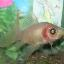

In [ ]:
display(train['image'][0])

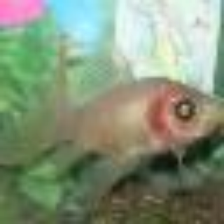

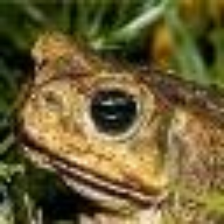

In [ ]:
 # Retrieve the transformed image from the dataset
transformed_image, label = train_dataset.__getitem__(0)

# Convert the tensor back to a PIL image
image_to_display = tensor_to_pil_image(transformed_image)

# Display the image using PIL
display(image_to_display)

transformed_image, label = train_dataset.__getitem__(1500)
# Convert the tensor back to a PIL image
image_to_display = tensor_to_pil_image(transformed_image)

# Display the image using PIL
display(image_to_display)

In [ ]:
display(train_dataset.__getitem__(0)[0])
print(type(train_dataset.__getitem__(0)[0]))
print(np.array(train_dataset.__getitem__(0)[0]).shape)

tensor([[[ 2.2489,  2.2489,  2.2489,  ...,  0.3652,  0.0569,  0.0569],
         [ 2.2489,  2.2489,  2.2489,  ...,  0.3652,  0.0569,  0.0569],
         [ 2.2489,  2.2489,  2.2489,  ...,  0.3481,  0.0398,  0.0398],
         ...,
         [-0.5596, -0.5596, -0.5596,  ..., -0.8164, -0.8335, -0.8335],
         [-0.5596, -0.5596, -0.5596,  ..., -0.8678, -0.8849, -0.8849],
         [-0.5596, -0.5596, -0.5596,  ..., -0.8678, -0.8849, -0.8849]],

        [[ 0.3452,  0.3452,  0.3452,  ...,  1.1155,  0.8179,  0.8179],
         [ 0.3452,  0.3452,  0.3452,  ...,  1.1155,  0.8179,  0.8179],
         [ 0.3102,  0.3102,  0.3102,  ...,  1.0980,  0.8004,  0.8004],
         ...,
         [ 0.0476,  0.0476,  0.0476,  ..., -0.8978, -0.9153, -0.9153],
         [ 0.0476,  0.0476,  0.0476,  ..., -0.9503, -0.9678, -0.9678],
         [ 0.0476,  0.0476,  0.0476,  ..., -0.9503, -0.9678, -0.9678]],

        [[ 1.5594,  1.5594,  1.5594,  ...,  1.2980,  1.0017,  1.0017],
         [ 1.5594,  1.5594,  1.5594,  ...,  1

<class 'torch.Tensor'>
(3, 224, 224)


In [ ]:
def attack(classifier, image, label, adv_image, steps, checkpoint):
  #assumes that classifier correctly classifies image at beginning
  '''classifier is pretrained imagenet classifier, image is clean input,
  adv_image is random image from other class, label is is correct label of image,
  steps is max # of swaps, checkpoint is check output every X steps
  This outputs the corrupted image'''
  if classifier != None:
    classifier.eval()
  image_array = np.array(image)
  adv_array = np.array(adv_image)

  channel, width, height = image_array.shape
  print(f'SHAPE IS {image_array.shape}')
  #every check_point swaps check if it classifies it correctly
  for i in range(steps):
    if steps % checkpoint == 0:
      if classifier != None:
        if classifier(adv_image) != label:
          noised_image = adv_image
          print(f'Step {i}, we fooled classifier.')
          return image_array
      else:
        print(f'Step {i}, not yet fooled.')
    random_x = random.randint(0, height - 1)
    random_y = random.randint(0, width - 1)
    image_array[:, random_x, random_y] = (
    adv_array[:, random_x, random_y])

  #all steps done, not fooled
  print(f'After {steps} steps, not fooled.')
  print(image_array.shape)
  return image_array # numpy array



<class 'torch.Tensor'>
(3, 224, 224)
SHAPE IS (3, 224, 224)
Step 0, not yet fooled.
Step 1, not yet fooled.
Step 2, not yet fooled.
Step 3, not yet fooled.
Step 4, not yet fooled.
Step 5, not yet fooled.
Step 6, not yet fooled.
Step 7, not yet fooled.
Step 8, not yet fooled.
Step 9, not yet fooled.
Step 10, not yet fooled.
Step 11, not yet fooled.
Step 12, not yet fooled.
Step 13, not yet fooled.
Step 14, not yet fooled.
Step 15, not yet fooled.
Step 16, not yet fooled.
Step 17, not yet fooled.
Step 18, not yet fooled.
Step 19, not yet fooled.
Step 20, not yet fooled.
Step 21, not yet fooled.
Step 22, not yet fooled.
Step 23, not yet fooled.
Step 24, not yet fooled.
Step 25, not yet fooled.
Step 26, not yet fooled.
Step 27, not yet fooled.
Step 28, not yet fooled.
Step 29, not yet fooled.
Step 30, not yet fooled.
Step 31, not yet fooled.
Step 32, not yet fooled.
Step 33, not yet fooled.
Step 34, not yet fooled.
Step 35, not yet fooled.
Step 36, not yet fooled.
Step 37, not yet fooled.


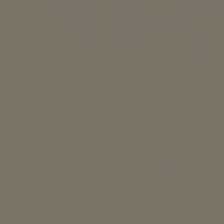

In [ ]:
first_fish = train_dataset.__getitem__(0)[0]
print(type(first_fish))
print(np.array(first_fish).shape)
first_frog = train_dataset.__getitem__(1500)[0]
noised_image = attack(classifier=None, image=first_fish, label=0, adv_image=first_frog, steps=40, checkpoint=5)
print(type(noised_image))
noised_image_tensor = torch.from_numpy(noised_image).float() / 255.0  # Scale to [0, 1]
print(type(noised_image_tensor))
print(noised_image_tensor.shape)
# Pass the tensor to the function
noised_image = tensor_to_pil_image(noised_image_tensor)
display(noised_image)